# Actor - Critic methods

In [ ]:
# Google Colab:
!pip3 install box2d-py
!pip3 install gym[Box_2D]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 6.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import math
import copy
import time
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

np.set_printoptions(precision=3, suppress=True)

class Memory:
    def __init__(self, capacity, nS, nA):
        self.capacity = capacity  # memory capacity (number of examples)
        self.count    = 0         # number of examples added
        self.S0 = torch.empty( (capacity, nS), dtype=torch.float32)
        self.S1 = torch.empty( (capacity, nS), dtype=torch.float32)        
        self.A0 = torch.empty( (capacity, nA),  dtype=torch.float32)
        self.R1 = torch.empty( (capacity, 1),  dtype=torch.float32)
        self.Dn = torch.empty( (capacity, 1),  dtype=torch.float32)

    def add(self, s0, a0, s1, r1, done):
        """ Add to memory (s0,a0,s1,r1, done) """
        idx = self.count % self.capacity
        self.S0[idx] = torch.tensor(s0, dtype=torch.float32)
        self.S1[idx] = torch.tensor(s1, dtype=torch.float32)
        self.A0[idx] = torch.tensor(a0, dtype=torch.float32)
        self.R1[idx] = r1;  self.Dn[idx] = done
        self.count += 1

    def get(self, count):
        """ Return count of examples for (s0,s1,r1, dn) """        
        high = min(self.count, self.capacity)
        num  = min(count, high)
        ids = torch.randint(high = high, size = (num,) )
        return self.S0[ids], self.S1[ids], self.A0[ids], self.R1[ids], self.Dn[ids]
        
#========================================================================================

class ActorModel(nn.Module):
    """ Neural network for pi(a|s) """
    def __init__(self, nS, nA, hiddens):
        super(ActorModel, self).__init__()
        
        neurons, layers = [nS] + hiddens, []        
        for i in range(len(neurons)-1):
            layers.append(nn.Linear(neurons[i], neurons[i+1]) )            
            layers.append( nn.ReLU() )
        self.base = nn.Sequential(*layers)

        self.mu = nn.Sequential(
            nn.Linear(neurons[-1], nA),
            nn.Tanh()                   # action in [-1...1]
        )             
        self.std = nn.Sequential(
            nn.Linear(neurons[-1], nA),
            nn.Softplus()               # std > 0
        )         
         
        
    def forward(self, x):
        base = self.base(x)        
        return self.mu(base), self.std(base)        

#========================================================================================    

class CriticModel(nn.Module):
    """ Neural network for V(s) """
    def __init__(self, nS, nA, hiddens):
        super(CriticModel, self).__init__()
        
        neurons, layers = [nS] + hiddens + [1], []        
        for i in range(len(neurons)-1):
            layers.append(nn.Linear(neurons[i], neurons[i+1]) )
            if i < len(neurons)-2:
                layers.append( nn.ReLU() )
        
        self.model = nn.Sequential(*layers)
 
    def forward(self, x):
        return self.model(x)        

#========================================================================================    

class ActorCritic:
    """ A2C метод для дискретных действий """
    def __init__(self, env):
        self.env  = env                                # environment we work with
        self.low  = env.observation_space.low          # minimum observation values
        self.high = env.observation_space.high         # maximum observation values
        self.nA   =  self.env.action_space.shape[0]    # number of discrete actions
        self.nS   =  self.env.observation_space.shape[0] # number of state components

        self.eps1 = 1.
        self.eps2 = 0.01

        self.CFG = {                      # default parameters
            'env'         : "Environment",
            'ticks'       : 200,                  
            'timeout'     : True,            # whether to consider reaching ticks as a terminal state
            'method'      : "ac",            # kind of the method (a2c)     
            'gamma'       : 0.99,            # discount factor            
            'decays'      : 1,               # number of episodes to decay eps1=1.0 - > eps2=0.01
            'update'      : 10,              # target model update rate (in frames = time steps)         
            'batch_act'   : 100,             # batch size for training
            'batch_cri'   : 100,             # batch size for training
            'capacity'     : 10000,          # size memory 
            'actor'       : [256,128],       # hidden layers of actor
            'critic'      : [256,128],       # hidden layers of critic
            'scale'       : True,            # scale or not observe to [-1...1]
            'loss'        : 'huber',         # loss function (mse, huber)
            'optimizer'   : 'sgd',           # optimizer (sgd, adam)
            'std_max'     : 10,
            'lm_act'      : 0.001,           # learning rate for actor model
            'lm_cri'      : 0.001,           # learning rate for critic model
            'beta'        : 0.001,           # entropy
        }
        self.last_loss_act = 0.              # last loss of actor model
        self.last_loss_cri = 0.              # last loss of critic model
        self.history   = []

        print("low :   ", self.low)
        print("high:   ", self.high)        
        
    #------------------------------------------------------------------------------------

    def init(self):
        """ Create a neural network and optimizer """

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print("device:", self.device)

        self.actor  = ActorModel (self.nS, self.nA, self.CFG['actor']).to(self.device)   # actor
        self.critic = CriticModel(self.nS, self.nA, self.CFG['critic']).to(self.device)  # critic
        self.target = CriticModel(self.nS, self.nA, self.CFG['critic']).to(self.device)  # target  critic

        self.best_actor   = ActorModel(self.nS, self.nA, self.CFG['actor'])               # best actor
        self.best_critic  = CriticModel(self.nS, self.nA, self.CFG['critic'])               # best actor
        self.best_reward = -100000                                                       # best reward
        
        if   self.CFG['optimizer'] == 'sgd':
            self.optim_act = torch.optim.SGD(self.actor.parameters(),   lr=self.CFG['lm_act'], momentum=0.8)
            self.optim_cri = torch.optim.SGD(self.critic.parameters(),  lr=self.CFG['lm_cri'], momentum=0.8)
        elif self.CFG['optimizer'] == 'adam':
            self.optim_act = torch.optim.Adam(self.actor.parameters(),  lr=self.CFG['lm_act'])
            self.optim_cri = torch.optim.Adam(self.critic.parameters(), lr=self.CFG['lm_cri'])
        else:
            print("ERROR: Unknown optimizer!!!")

        self.memo  = Memory (self.CFG['capacity'], self.nS, self.nA)        
        
        self.V1, self.mu, self.std = None, None, None         
        
        self.epsilon     = self.eps1         # start value in epsilon greedy strategy
        self.decay_rate  = math.exp(math.log(self.eps2/self.eps1)/self.CFG['decays'])

        print(f"decay_rate: {self.decay_rate:.4f}")
       
    #------------------------------------------------------------------------------------

    def scale(self, obs):
        """ to [-1...1] """
        if self.CFG['scale']:
            return -1. + 2.*(obs - self.low)/(self.high-self.low)
        else:
            return obs
        
    #------------------------------------------------------------------------------------

    def policy(self, state):
        """ Return action according to epsilon greedy strategy """
        if np.random.random() < self.epsilon:            
            actions = np.random.normal( size=(self.nA,) )
            #actions = np.array([1 if state[1] > 0 else -1])
            return np.clip(actions, -1, 1)      # random action

        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        mu, std = self.actor( state )
     
        mu  = mu.data.cpu().numpy()
        std = std.data.cpu().numpy()
     
        actions = np.random.normal(mu, std)
        
        return np.clip(actions, -1, 1)            
        
    #------------------------------------------------------------------------------------

    def run_episode(self, ticks = 200):
        """ Run one episode, keeping the environment model in memory """      
        if self.CFG['online'] > 0:
            self.memo.count = 0                  # !!!      

        rew = 0                                  # total reward
        s0 = self.env.reset()                    # initial state
        s0 = self.scale (s0)                     # scale it
        a0 = self.policy(s0)                     # get action
        for t in range(1, ticks+1):
            s1, r1, done, _ = self.env.step(a0)
            s1 = self.scale (s1)
            a1 = self.policy(s1)

            if self.CFG['online'] == 2:
                self.memo.count = 0              # !!!                 

            dn = done and (self.CFG['timeout'] or t < ticks)                        
            self.memo.add(s0, a0, s1, r1, float(dn) )            

            if self.CFG['update'] > 0 and self.frame % self.CFG['update'] == 0: 
                self.target.load_state_dict( self.critic.state_dict() )                              

            if self.CFG['online'] > 0:            
                self.learn_critic()
                self.learn_actor()

            rew += r1
            self.frame += 1

            if done:
                break

            s0, a0 = s1, a1
                
        if self.CFG['online'] == 0:                    
            self.learn_critic()                                                                                 
            self.learn_actor()                     

        return rew, t

    #------------------------------------------------------------------------------------

    def learn(self, episodes = 100000, stat1 = 1, stat2 = 100, plots = 100, rews_range=[-200, -80]):
        """ Repeat episodes episodes times """        
        self.frame = 1        
        rews, lens, mean, beg   = [], [], 0, time.process_time()
        for episode in range(1, episodes+1):
            rew, t = self.run_episode( self.CFG['ticks'] )
            rews.append( rew )
            lens.append(t)
            
            self.epsilon *= self.decay_rate                # epsilon-decay
            if self.epsilon < self.eps2:
                self.epsilon = 0.
            
            #if self.memo.count >= self.CFG['capacity']:
            if episode % stat1 == 0:
                self.history.append([episode, np.mean(rews[-stat1:]), np.mean(rews[-stat2:])])                                      
                
            if  episode % 10 == 0:                               
                mean, std, mi, ma    = np.mean(rews[-stat2:]), np.std(rews[-stat2:]), np.min(rews[-stat2:]), np.max(rews[-stat2:])
                lensM, lensS = np.mean(lens[-stat2:]), np.std(lens[-stat2:])                    
                if mean > self.best_reward:
                    self.best_reward = mean
                    self.best_actor. load_state_dict( self.actor.state_dict() )
                    self.best_critic.load_state_dict( self.critic.state_dict() )
                V   = self.V1  if self.V1  != None else []
                print(f"{episode:6d} rew:{mean:7.1f} ± {std/stat2**0.5:3.1f} [{mi:.2f},{ma:.2f}], best:{self.best_reward:7.2f}, ticks:{lensM:3.0f}, eps:{self.epsilon:.3f}, mu:{self.mu}, std:{self.std}, V:{V.mean():6.2f} ±{V.std():6.2f} {V.shape}, losses (cri:{self.last_loss_cri:8.4f}, act:{self.last_loss_act:8.4f}),  {(time.process_time() - beg):3.0f}s")
                beg = time.process_time()
                
            if  episode % plots == 0:                   
                self.plot(f"{self.CFG['env']}  Episode: {episode}  best: {self.best_reward:7.1f}", rews_range)
            
    #------------------------------------------------------------------------------------

    def learn_critic(self):
        """ Critic model training """                
        S0, S1, _, R1, D1 = self.memo.get(self.CFG['batch_cri'])
        S0 = S0.to(self.device);  S1 = S1.to(self.device); 
        R1 = R1.to(self.device);  D1 = D1.to(self.device)                
        
        V0 = self.critic(S0)        
        if self.CFG['update'] > 0:
            with torch.no_grad():
                V1 = self.target(S1)   
        else:
            V1 = self.critic(S1)   
                
        loss = ((R1 + self.CFG['gamma']*V1*(1.-D1) -  V0)**2).mean()
        
        self.optim_cri.zero_grad()       # reset the gradients
        loss.backward()                  # calculate gradients
        self.optim_cri.step()            # adjusting parameters        

        self.last_loss_cri = loss.item()
        self.V1 = V1.detach().cpu()

    #------------------------------------------------------------------------------------

    def learn_actor(self):
        S0, S1, A0,  R1, _  = self.memo.get(self.CFG['batch_act'])
        S0 = S0.to(self.device);  A0 = A0.to(self.device); 
        S1 = S1.to(self.device);  R1 = R1.to(self.device); 
        
        with torch.no_grad():
            V0  = self.critic(S0)
            V1  = self.critic(S1)
            Adv = R1 + self.CFG['gamma']*V1 - V0
        
        mu, std = self.actor(S0)
        std = std.clamp( self.CFG['std_min'], self.CFG['std_max']) 

        log_pi = -0.5*( ((mu - A0) / std )**2 + torch.log(2 * math.pi * std**2) )
                 
        loss = - ( (Adv * log_pi).mean() + self.CFG["beta"] * torch.log( std ) ).mean()
        
        self.optim_act.zero_grad()        # reset the gradients
        loss.backward()                   # calculate gradients                    
        self.optim_act.step()             # adjusting parameters             
                
        self.last_loss_act = loss.item()        
        self.mu  = mu.detach().mean(0).cpu().numpy()
        self.std = std.detach().mean(0).cpu().numpy()
        
    #------------------------------------------------------------------------------------
        
    def plot(self, text, rews_range):
        """ Plot histogram for states and actions """             
        num = min(self.memo.count, self.memo.capacity)
        hist_S, bins_S = np.histogram(self.memo.S1[:num], bins=np.linspace(0, math.sqrt(self.nS), 101),   density=True)        
        hist_A, bins_A = np.histogram(self.memo.A0[:num].mean(1),  density=True)

        fig, ax = plt.subplots(1, 3, figsize=(16,6), gridspec_kw={'width_ratios': [2, 1, 5]})        
        plt.suptitle(text, fontsize=18)
                                
        ax[0].set_xlim(min(bins_S), max(bins_S))    # histogram for S1
        ax[0].grid(axis='x', alpha=0.75); ax[0].grid(axis='y', alpha=0.75)
        ax[0].set_xlabel('|s1|', fontsize=16)
        bins = [ (bins_S[i]+bins_S[i+1])/2 for i in range(len(bins_S)-1)]
        ax[0].bar(bins, hist_S, width=0.5, color='blue')
                        
        ax[1].set_xlim(min(bins_A), max(bins_A))    # histogram for A
        ax[1].grid(axis='x', alpha=0.75); ax[1].grid(axis='y', alpha=0.75)
        ax[1].set_xlabel('actions', fontsize=16)
        ax[1].set_xticks(np.arange(self.nA));
        bins = [ (bins_A[i]+bins_A[i+1])/2 for i in range(len(bins_A)-1)]        
        ax[1].bar(bins, hist_A, width=0.5, color='blue')

        history = np.array(self.history)            # loss history
        ax[2].plot(history[:,0], history[:,1], linewidth=1)
        ax[2].plot(history[:,0], history[:,2], linewidth=2)
        ax[2].set_ylim(rews_range[0], rews_range[1]);
        ax[2].set_xlabel('episode', fontsize=16)        
        ax[2].grid(axis='x', alpha=0.75); ax[2].grid(axis='y', alpha=0.75)
        params = [ f"{k:9s}: {v}\n" for k,v in self.CFG.items()]
        ax[2].text(history[0,0], rews_range[0], "".join(params), {'fontsize':12, 'fontname':'monospace'})

        plt.show()
        
    #------------------------------------------------------------------------------------

    def test(self, episodes = 1000, ticks = 1000, render = False):
        """ Q-Function Testing """
        rews = []
        for episode in range(1, episodes+1):
            tot = 0
            obs =  self.env.reset()
            for _ in range(ticks):
                action = self.policy( self.scale(obs) )
                obs, rew, done, _ = self.env.step(action)
                tot += rew
                if render:
                    env.render()
                if done:
                    break
            rews.append(tot)
            if episode % 100:
                print(f"\r {episode:4d}: Reward: {np.mean(rews):7.3f} ± {np.std(rews)/len(rews)**0.5:.3f}", end="")
        print()


## MountainCar Continuous¶

low :    [-1.2  -0.07]
high:    [0.6  0.07]
device: cuda:0
decay_rate: 0.0100
{'env': 'MountainCarContinuous-v0', 'ticks': 1000, 'timeout': True, 'method': 'ac', 'gamma': 0.99, 'decays': 1, 'capacity': 10000, 'actor': [64, 64], 'critic': [512, 512], 'online': 2, 'update': -1, 'std_min': 0.01, 'std_max': 3, 'scale': True, 'optimizer': 'adam', 'batch_act': 1000, 'batch_cri': 1000, 'lm_act': 1e-05, 'lm_cri': 0.001, 'beta': 0}
    10 rew:  -22.4 ± 1.1 [-52.16,-11.88], best: -22.38, ticks:999, eps:0.000, mu:[-0.081], std:[0.288], V: -1.33 ±   nan torch.Size([1, 1]), losses (cri:  1.7518, act: -0.0009),   54s
    20 rew:  -14.5 ± 1.1 [-52.16,-4.18], best: -14.54, ticks:999, eps:0.000, mu:[-0.028], std:[0.202], V:  1.23 ±   nan torch.Size([1, 1]), losses (cri:  1.4849, act: -0.0033),   55s
    30 rew:  -10.7 ± 1.1 [-52.16,-2.44], best: -10.66, ticks:999, eps:0.000, mu:[0.086], std:[0.148], V: -0.18 ±   nan torch.Size([1, 1]), losses (cri:  0.0286, act: -0.0015),   55s
    40 rew:   -8.3 ± 1.0

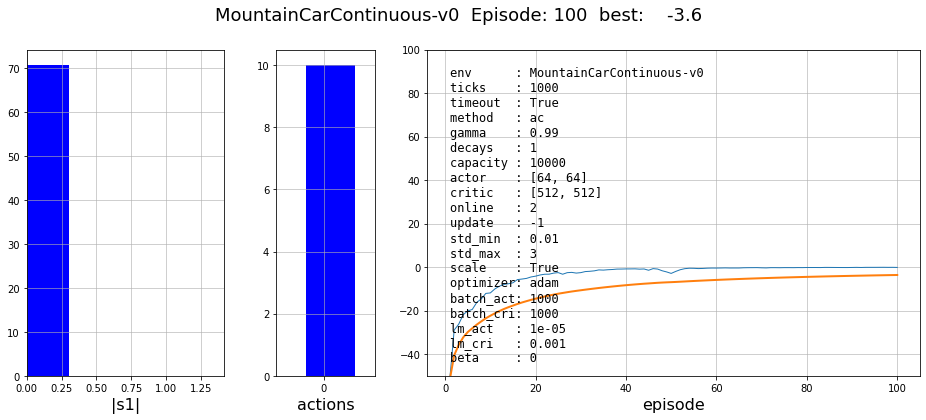

   110 rew:   -1.4 ± 0.2 [-10.05,-0.08], best:  -1.41, ticks:999, eps:0.000, mu:[-0.005], std:[0.025], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0037),   56s
   120 rew:   -0.8 ± 0.1 [-3.64,-0.07], best:  -0.75, ticks:999, eps:0.000, mu:[-0.021], std:[0.018], V: -0.01 ±   nan torch.Size([1, 1]), losses (cri:  0.0001, act:  0.0055),   55s
   130 rew:   -0.5 ± 0.1 [-2.91,-0.05], best:  -0.47, ticks:999, eps:0.000, mu:[-0.006], std:[0.018], V: -0.01 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0046),   55s
   140 rew:   -0.3 ± 0.0 [-2.91,-0.05], best:  -0.34, ticks:999, eps:0.000, mu:[-0.003], std:[0.021], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0035),   55s
   150 rew:   -0.2 ± 0.0 [-2.00,-0.04], best:  -0.21, ticks:999, eps:0.000, mu:[0.004], std:[0.018], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0025),   55s
   160 rew:   -0.1 ± 0.0 [-0.43,-0.03], best:  -0.14, ticks:999, eps:0.000, mu:[-0.003], s

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


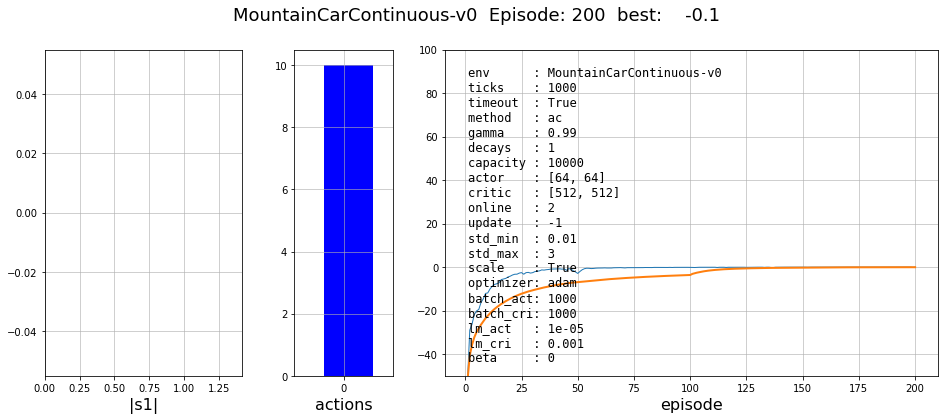

   210 rew:   -0.1 ± 0.0 [-0.19,-0.01], best:  -0.05, ticks:999, eps:0.000, mu:[-0.002], std:[0.011], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0036),   56s
   220 rew:   -0.0 ± 0.0 [-0.19,-0.01], best:  -0.05, ticks:999, eps:0.000, mu:[0.002], std:[0.011], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0036),   55s
   230 rew:   -0.0 ± 0.0 [-0.19,-0.01], best:  -0.04, ticks:999, eps:0.000, mu:[-0.001], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0032),   55s
   240 rew:   -0.0 ± 0.0 [-0.18,-0.01], best:  -0.04, ticks:999, eps:0.000, mu:[0.002], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0029),   55s
   250 rew:   -0.0 ± 0.0 [-0.18,-0.01], best:  -0.04, ticks:999, eps:0.000, mu:[0.], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0047),   55s
   260 rew:   -0.0 ± 0.0 [-0.18,-0.01], best:  -0.03, ticks:999, eps:0.000, mu:[0.], std:[0.01], V:

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


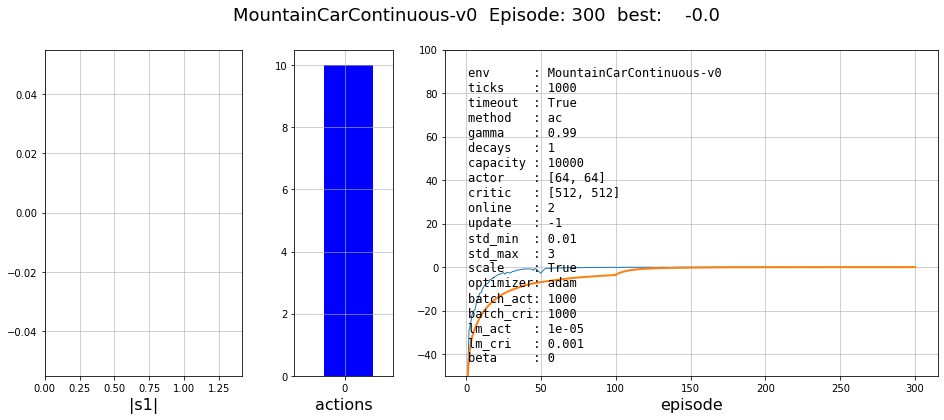

   310 rew:   -0.0 ± 0.0 [-0.29,-0.01], best:  -0.03, ticks:999, eps:0.000, mu:[-0.002], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0014),   56s
   320 rew:   -0.0 ± 0.0 [-0.29,-0.01], best:  -0.03, ticks:999, eps:0.000, mu:[0.001], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0029),   55s
   330 rew:   -0.0 ± 0.0 [-0.29,-0.01], best:  -0.03, ticks:999, eps:0.000, mu:[-0.008], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0042),   55s
   340 rew:   -0.0 ± 0.0 [-0.29,-0.01], best:  -0.03, ticks:999, eps:0.000, mu:[0.004], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0013),   55s
   350 rew:   -0.0 ± 0.0 [-0.29,-0.01], best:  -0.03, ticks:999, eps:0.000, mu:[0.], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0027),   54s
   360 rew:   -0.0 ± 0.0 [-0.29,-0.01], best:  -0.03, ticks:999, eps:0.000, mu:[-0.007], std:[0.01], 

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


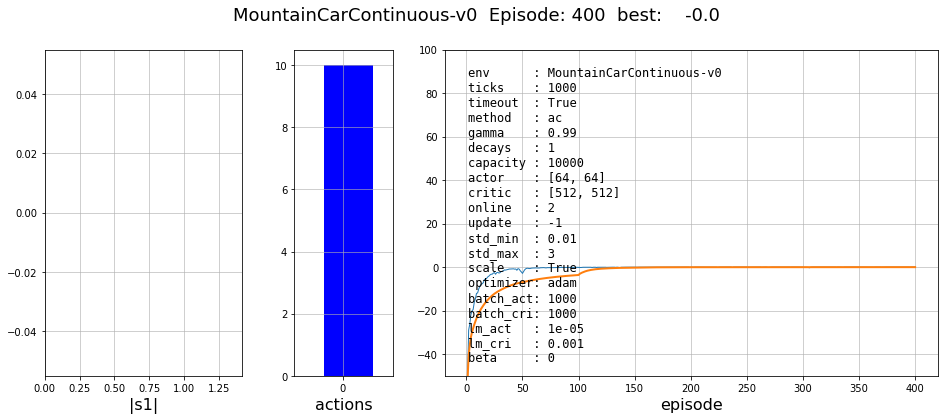

   410 rew:   -0.0 ± 0.0 [-0.09,-0.01], best:  -0.02, ticks:999, eps:0.000, mu:[-0.007], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0028),   55s
   420 rew:   -0.0 ± 0.0 [-0.09,-0.01], best:  -0.02, ticks:999, eps:0.000, mu:[0.001], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0008),   54s
   430 rew:   -0.0 ± 0.0 [-0.09,-0.01], best:  -0.02, ticks:999, eps:0.000, mu:[0.001], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0032),   54s
   440 rew:   -0.0 ± 0.0 [-0.09,-0.01], best:  -0.02, ticks:999, eps:0.000, mu:[-0.], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0030),   54s
   450 rew:   -0.0 ± 0.0 [-0.11,-0.01], best:  -0.02, ticks:999, eps:0.000, mu:[-0.018], std:[0.01], V: -0.00 ±   nan torch.Size([1, 1]), losses (cri:  0.0000, act:  0.0032),   54s
   460 rew:   -0.0 ± 0.0 [-0.17,-0.01], best:  -0.02, ticks:999, eps:0.000, mu:[-0.004], std:[0.01],

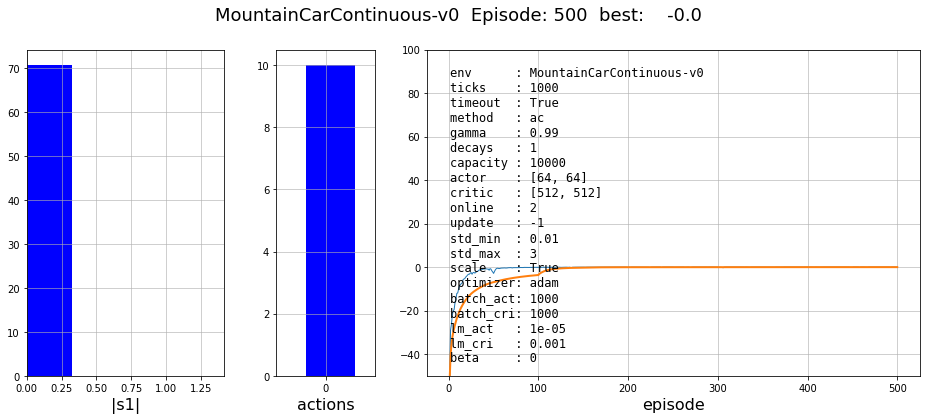

In [ ]:
env_name = "MountainCarContinuous-v0"  # (nS=2, nA=1)  reward = -0.1 * action**2
env = gym.make(env_name)

ac = ActorCritic( env )

ac.CFG = {                   # default parameters
            'env'         : env_name,          
            'ticks'       : 1000,            # !!!!!!!
            'timeout'     : True,           # whether to consider reaching ticks as a terminal state
            'method'      : "ac",            # kind of the method (a2c)     
            'gamma'       : 0.99,            # discount factor
            'decays'      : 1,               # number of episodes to decay eps1=1.0 - > eps2=0.01
            'capacity'    : 10000,           # size of memory            
            'actor'       : [64,64],         # hidden layers of actor
            'critic'      : [512,512],       # hidden layers of critic
            'online'      : 2,               # 0,1,2
            'update'      : -1,               # target model update rate (in frames = time steps)                     
            'std_min'     : 0.01,
            'std_max'     : 3,
            'scale'       : True,            # scale or not observe to [-1...1]            
            'optimizer'   : 'adam',          # optimizer (sgd, adam)                        
            'batch_act'   : 1000,            # batch size for training
            'batch_cri'   : 1000,            # batch size for training
            'lm_act'      : 1e-5,            # learning rate for actor model
            'lm_cri'      : 1e-3,            # learning rate for critic model
            'beta'        : 0,               # entropy    
}

ac.init()
print(ac.CFG)
ac.learn(episodes = 500,  rews_range=[-50, 100])

## Bipedal Walker

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


low :    [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
high:    [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf]
device: cuda:0
decay_rate: 0.0100
{'env': 'BipedalWalker-v3', 'ticks': 2000, 'timeout': True, 'method': 'ac', 'gamma': 0.99, 'decays': 1, 'capacity': 10000, 'actor': [64, 64], 'critic': [512, 512], 'online': 2, 'update': -1, 'std_min': 0.01, 'std_max': 3, 'scale': False, 'optimizer': 'adam', 'batch_act': 1000, 'batch_cri': 1000, 'lm_act': 1e-06, 'lm_cri': 1e-05, 'beta': 0.01}
    10 rew: -105.3 ± 1.3 [-130.71,-84.10], best:-105.35, ticks:680, eps:0.000, mu:[-0.043  0.143 -0.137 -0.019], std:[0.72  0.703 0.671 0.672], V: -0.56 ±   nan torch.Size([1, 1]), losses (cri:  0.3301, act:  0.0187),   58s
    20 rew: -101.4 ± 1.1 [-130.71,-84.10], best:-101.43, ticks:609, eps:0.000, mu:[-0.067  0.126 -0.136 -0.028], std:[0.731 0.707 0.676 0.669], V: -0.99 ±   

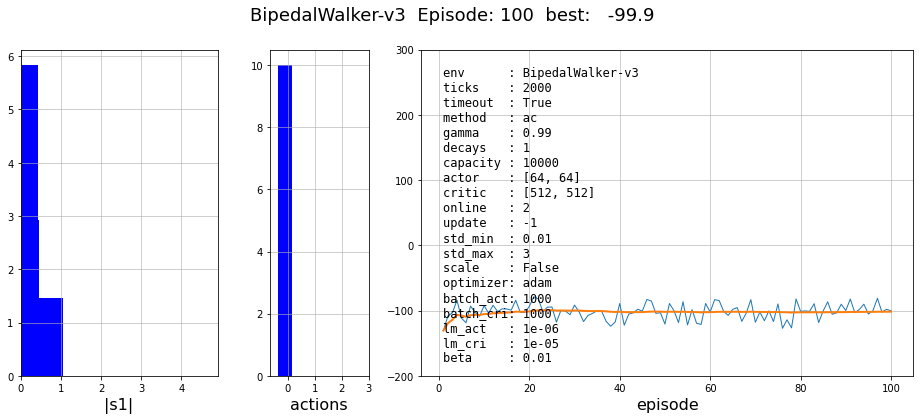

   110 rew: -101.8 ± 1.1 [-127.20,-78.71], best: -99.88, ticks:495, eps:0.000, mu:[ 0.047  0.051 -0.046 -0.074], std:[0.72  0.717 0.667 0.721], V: -6.97 ±   nan torch.Size([1, 1]), losses (cri:8653.6875, act:-74.8863),    9s
   120 rew: -101.8 ± 1.2 [-127.20,-76.39], best: -99.88, ticks:525, eps:0.000, mu:[ 0.104  0.032 -0.093 -0.054], std:[0.708 0.755 0.629 0.716], V: -8.40 ±   nan torch.Size([1, 1]), losses (cri:8328.0762, act:-112.9521),   72s
   130 rew: -103.4 ± 1.5 [-187.29,-76.39], best: -99.88, ticks:523, eps:0.000, mu:[ 0.037  0.129 -0.093 -0.052], std:[0.754 0.699 0.664 0.698], V: -8.22 ±   nan torch.Size([1, 1]), losses (cri: 67.6796, act:  0.0608),   70s
   140 rew: -102.4 ± 1.5 [-187.29,-76.39], best: -99.88, ticks:569, eps:0.000, mu:[ 0.005  0.137 -0.11   0.001], std:[0.724 0.705 0.68  0.665], V: -9.01 ±   nan torch.Size([1, 1]), losses (cri: 80.9123, act:  0.0621),   59s
   150 rew: -101.9 ± 1.5 [-187.29,-76.39], best: -99.88, ticks:582, eps:0.000, mu:[ 0.063  0.05  -0.0

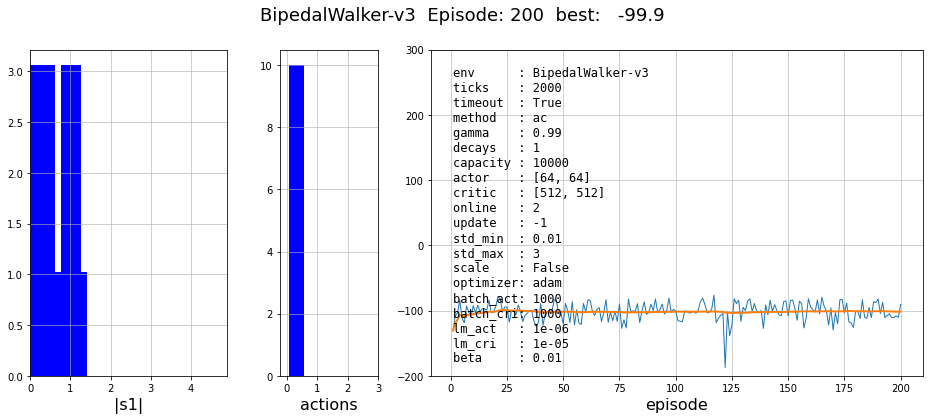

   210 rew: -101.0 ± 1.6 [-187.29,-76.39], best: -99.88, ticks:684, eps:0.000, mu:[ 0.01   0.096 -0.081 -0.045], std:[0.722 0.699 0.725 0.677], V:-12.77 ±   nan torch.Size([1, 1]), losses (cri:7436.6885, act:-107.1274),   47s
   220 rew: -102.0 ± 1.5 [-187.29,-79.41], best: -99.88, ticks:624, eps:0.000, mu:[-0.011  0.105 -0.037 -0.015], std:[0.716 0.725 0.707 0.713], V:-13.90 ±   nan torch.Size([1, 1]), losses (cri:7426.8374, act:-107.6574),   21s
   230 rew: -101.7 ± 1.3 [-135.50,-79.41], best: -99.88, ticks:571, eps:0.000, mu:[ 0.011  0.068 -0.062 -0.062], std:[0.734 0.692 0.705 0.679], V:-15.88 ±   nan torch.Size([1, 1]), losses (cri:7004.5630, act:-84.7725),   24s
   240 rew: -102.4 ± 1.3 [-135.50,-79.41], best: -99.88, ticks:525, eps:0.000, mu:[-0.036  0.116 -0.122 -0.093], std:[0.741 0.685 0.724 0.68 ], V:-17.57 ±   nan torch.Size([1, 1]), losses (cri:6575.5654, act:-67.7534),   20s
   250 rew: -102.1 ± 1.3 [-135.50,-77.56], best: -99.88, ticks:540, eps:0.000, mu:[ 0.092  0.051 -

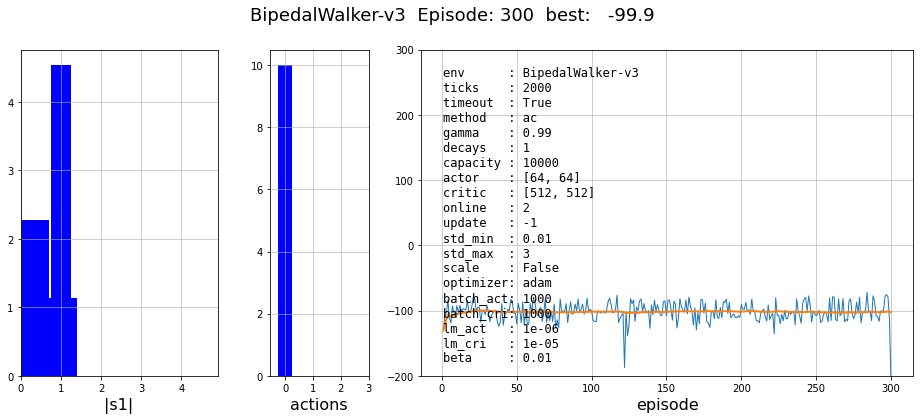

   310 rew: -102.4 ± 1.8 [-210.30,-71.81], best: -99.88, ticks:509, eps:0.000, mu:[ 0.04   0.049 -0.039 -0.113], std:[0.745 0.68  0.711 0.672], V:-26.09 ±   nan torch.Size([1, 1]), losses (cri:5273.2583, act:-61.3310),   60s
   320 rew: -101.0 ± 1.8 [-210.30,-71.81], best: -99.88, ticks:568, eps:0.000, mu:[ 0.102  0.096 -0.085  0.003], std:[0.733 0.669 0.652 0.642], V:-24.21 ±   nan torch.Size([1, 1]), losses (cri:577.6145, act:  0.0568),   72s
   330 rew:  -99.6 ± 1.8 [-210.30,-71.81], best: -99.57, ticks:609, eps:0.000, mu:[ 0.071  0.17  -0.143  0.063], std:[0.698 0.677 0.651 0.654], V:-25.06 ±   nan torch.Size([1, 1]), losses (cri:615.3537, act: -0.0090),   60s
   340 rew:  -98.8 ± 1.8 [-210.30,-69.78], best: -98.76, ticks:657, eps:0.000, mu:[-0.017  0.109 -0.075 -0.087], std:[0.729 0.673 0.692 0.682], V:-23.48 ±   nan torch.Size([1, 1]), losses (cri:5624.7412, act:-77.2642),   61s
   350 rew:  -98.3 ± 1.9 [-210.30,-69.78], best: -98.34, ticks:658, eps:0.000, mu:[ 0.05   0.172 -0.10

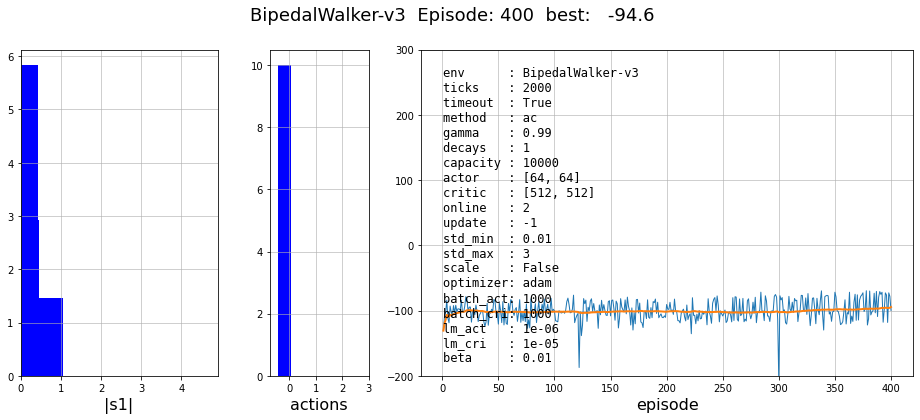

   410 rew:  -94.7 ± 1.7 [-129.83,-69.60], best: -94.58, ticks:751, eps:0.000, mu:[ 0.116  0.166 -0.137  0.112], std:[0.674 0.634 0.619 0.62 ], V:-22.65 ±   nan torch.Size([1, 1]), losses (cri:514.4960, act:  0.2617),   49s
   420 rew:  -95.5 ± 1.7 [-129.83,-69.60], best: -94.58, ticks:737, eps:0.000, mu:[ 0.08   0.157 -0.11   0.069], std:[0.688 0.633 0.624 0.615], V:-22.80 ±   nan torch.Size([1, 1]), losses (cri:519.3573, act:  0.1280),   61s
   430 rew:  -95.4 ± 1.8 [-129.83,-69.60], best: -94.58, ticks:752, eps:0.000, mu:[ 0.099  0.197 -0.144  0.123], std:[0.648 0.639 0.618 0.608], V:-23.24 ±   nan torch.Size([1, 1]), losses (cri:528.5726, act: -0.0185),   74s
   440 rew:  -95.8 ± 1.8 [-125.76,-69.60], best: -94.58, ticks:735, eps:0.000, mu:[ 0.056  0.086 -0.06  -0.065], std:[0.701 0.656 0.672 0.638], V:-25.51 ±   nan torch.Size([1, 1]), losses (cri:5279.5439, act:-73.0028),   47s
   450 rew:  -95.5 ± 1.8 [-125.76,-68.90], best: -94.58, ticks:749, eps:0.000, mu:[ 0.127  0.102 -0.119

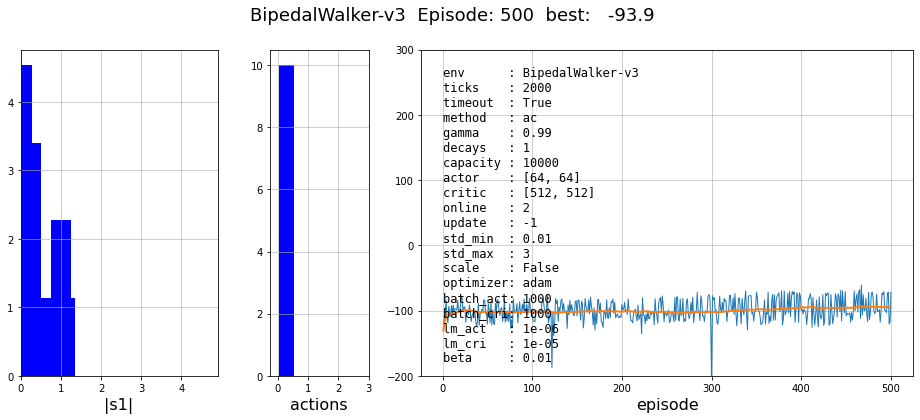

   510 rew:  -94.5 ± 1.8 [-125.76,-60.95], best: -93.90, ticks:702, eps:0.000, mu:[ 0.015  0.207 -0.103  0.006], std:[0.667 0.617 0.647 0.628], V:-27.66 ±   nan torch.Size([1, 1]), losses (cri:4948.1436, act:-103.5715),   60s
   520 rew:  -93.8 ± 1.8 [-122.81,-60.95], best: -93.81, ticks:701, eps:0.000, mu:[ 0.044  0.178 -0.111 -0.029], std:[0.69  0.612 0.658 0.592], V:-21.77 ±   nan torch.Size([1, 1]), losses (cri:5786.3638, act:-54.2296),   60s
   530 rew:  -94.1 ± 1.8 [-122.39,-60.95], best: -93.81, ticks:654, eps:0.000, mu:[ 0.05   0.087 -0.058 -0.051], std:[0.691 0.667 0.639 0.677], V:-39.75 ±   nan torch.Size([1, 1]), losses (cri:3269.0171, act:-78.5704),   33s
   540 rew:  -93.6 ± 1.8 [-124.44,-60.95], best: -93.64, ticks:669, eps:0.000, mu:[ 0.092  0.141 -0.114  0.014], std:[0.657 0.644 0.594 0.635], V:-38.90 ±   nan torch.Size([1, 1]), losses (cri:3554.6299, act:-107.8989),   59s
   550 rew:  -94.2 ± 1.9 [-124.44,-60.95], best: -93.64, ticks:640, eps:0.000, mu:[-0.022  0.123 -

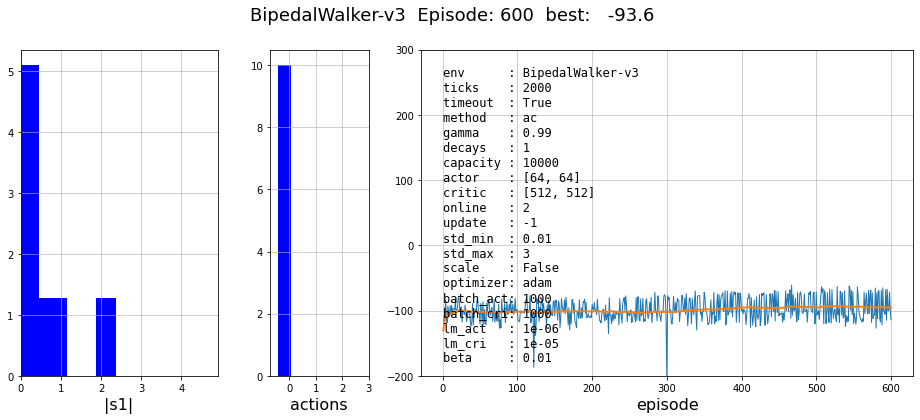

   610 rew:  -94.3 ± 2.0 [-127.07,-62.43], best: -93.64, ticks:671, eps:0.000, mu:[ 0.055  0.122 -0.065  0.007], std:[0.658 0.622 0.662 0.609], V:-24.71 ±   nan torch.Size([1, 1]), losses (cri:5364.7534, act:-93.2572),  101s
   620 rew:  -93.5 ± 2.0 [-127.07,-62.43], best: -93.47, ticks:688, eps:0.000, mu:[ 0.055  0.141 -0.06  -0.015], std:[0.674 0.652 0.635 0.67 ], V:-39.20 ±   nan torch.Size([1, 1]), losses (cri:3187.6057, act:-90.1961),   75s
   630 rew:  -92.4 ± 2.0 [-127.07,-62.43], best: -92.38, ticks:734, eps:0.000, mu:[ 0.095  0.219 -0.134  0.127], std:[0.622 0.577 0.583 0.571], V:-24.63 ±   nan torch.Size([1, 1]), losses (cri:592.8421, act: -0.0232),   73s
   640 rew:  -92.6 ± 2.1 [-127.07,-62.43], best: -92.38, ticks:720, eps:0.000, mu:[-0.011  0.184 -0.047  0.061], std:[0.647 0.581 0.633 0.605], V:-20.27 ±   nan torch.Size([1, 1]), losses (cri:5895.0396, act:-77.2416),   47s
   650 rew:  -93.2 ± 2.0 [-127.07,-61.45], best: -92.38, ticks:688, eps:0.000, mu:[ 0.051  0.122 -0.0

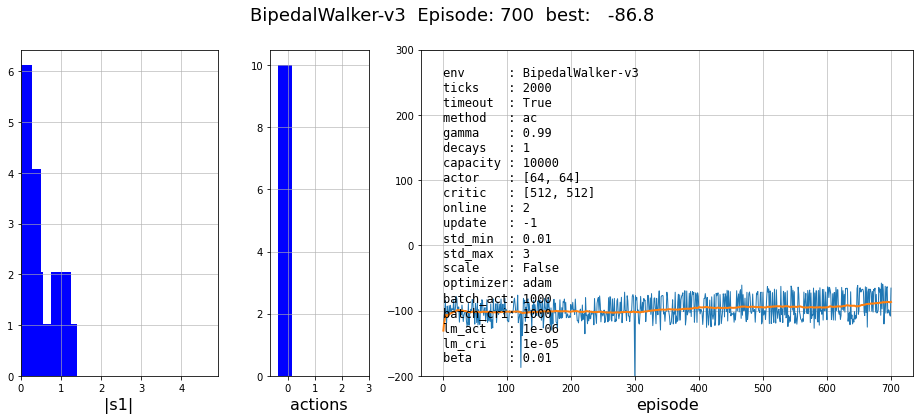

   710 rew:  -87.9 ± 2.1 [-125.38,-57.89], best: -86.82, ticks:810, eps:0.000, mu:[ 0.039  0.172 -0.073 -0.058], std:[0.666 0.605 0.642 0.593], V:-25.23 ±   nan torch.Size([1, 1]), losses (cri:5196.1406, act:-83.0649),   60s
   720 rew:  -87.8 ± 2.0 [-125.38,-57.89], best: -86.82, ticks:808, eps:0.000, mu:[ 0.132  0.233 -0.131  0.126], std:[0.589 0.55  0.562 0.545], V:-16.72 ±   nan torch.Size([1, 1]), losses (cri:276.4131, act:  0.0907),   73s
   730 rew:  -87.7 ± 2.1 [-125.38,-57.89], best: -86.82, ticks:809, eps:0.000, mu:[ 0.062  0.09  -0.021 -0.071], std:[0.691 0.595 0.615 0.618], V:-46.50 ±   nan torch.Size([1, 1]), losses (cri:2552.7507, act:-92.3526),   73s
   740 rew:  -86.1 ± 2.0 [-125.38,-57.89], best: -86.12, ticks:854, eps:0.000, mu:[ 0.033  0.12  -0.025 -0.088], std:[0.686 0.622 0.635 0.663], V:-46.23 ±   nan torch.Size([1, 1]), losses (cri:2417.0886, act:-85.3699),   87s
   750 rew:  -85.9 ± 2.0 [-125.38,-57.89], best: -85.90, ticks:854, eps:0.000, mu:[ 0.11   0.125 -0.0

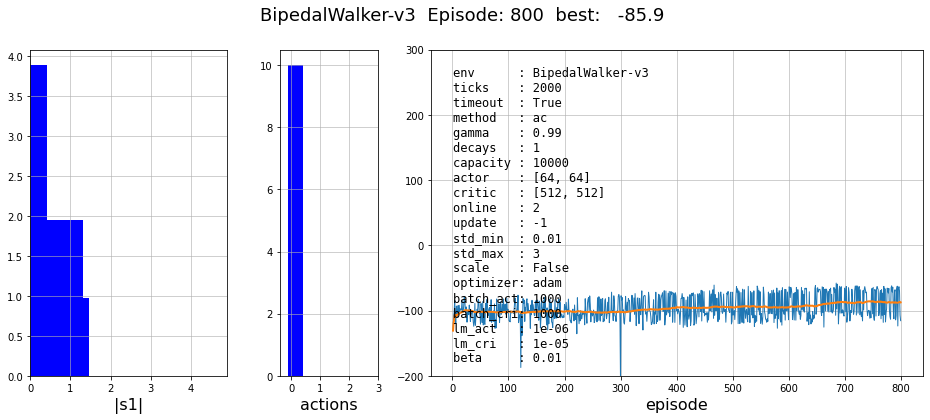

   810 rew:  -86.9 ± 2.0 [-123.60,-62.00], best: -85.90, ticks:852, eps:0.000, mu:[ 0.161  0.179 -0.174  0.095], std:[0.592 0.628 0.58  0.614], V:-44.06 ±   nan torch.Size([1, 1]), losses (cri:2747.8831, act:-45.5293),   73s
   820 rew:  -86.0 ± 2.0 [-123.60,-61.03], best: -85.90, ticks:897, eps:0.000, mu:[ 0.125  0.263 -0.133  0.114], std:[0.581 0.537 0.554 0.552], V: -9.26 ±   nan torch.Size([1, 1]), losses (cri: 86.7658, act:  0.0750),  113s
   830 rew:  -86.7 ± 2.0 [-123.60,-56.25], best: -85.90, ticks:866, eps:0.000, mu:[ 0.15   0.196 -0.104  0.036], std:[0.609 0.539 0.547 0.532], V:-13.46 ±   nan torch.Size([1, 1]), losses (cri:186.9963, act:  0.2243),   46s
   840 rew:  -87.2 ± 2.1 [-123.60,-56.25], best: -85.90, ticks:835, eps:0.000, mu:[ 0.087  0.11  -0.073 -0.07 ], std:[0.634 0.647 0.628 0.609], V:-56.62 ±   nan torch.Size([1, 1]), losses (cri:1867.1868, act:-70.9447),   59s
   850 rew:  -86.9 ± 2.1 [-123.60,-56.25], best: -85.90, ticks:851, eps:0.000, mu:[ 0.135  0.224 -0.12

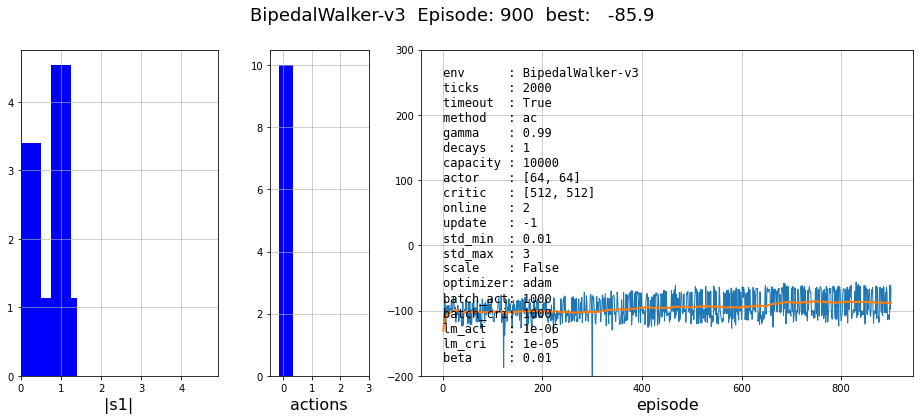

   910 rew:  -87.8 ± 2.0 [-121.60,-56.25], best: -85.90, ticks:792, eps:0.000, mu:[ 0.151  0.228 -0.138  0.069], std:[0.584 0.541 0.537 0.531], V:-11.84 ±   nan torch.Size([1, 1]), losses (cri:140.5882, act:  0.0660),  101s
   920 rew:  -89.3 ± 2.0 [-124.02,-56.25], best: -85.90, ticks:717, eps:0.000, mu:[ 0.154  0.269 -0.15   0.097], std:[0.572 0.533 0.542 0.544], V:-15.10 ±   nan torch.Size([1, 1]), losses (cri:222.1856, act: -0.0463),   47s
   930 rew:  -88.1 ± 2.0 [-124.02,-59.65], best: -85.90, ticks:778, eps:0.000, mu:[ 0.106  0.163 -0.075 -0.035], std:[0.644 0.644 0.6   0.664], V:-56.51 ±   nan torch.Size([1, 1]), losses (cri:1482.7585, act:-95.3508),   99s
   940 rew:  -88.8 ± 2.0 [-124.73,-60.98], best: -85.90, ticks:763, eps:0.000, mu:[ 0.163  0.231 -0.145  0.061], std:[0.564 0.537 0.528 0.524], V:-12.50 ±   nan torch.Size([1, 1]), losses (cri:148.9822, act: -0.1641),   46s
   950 rew:  -87.6 ± 2.0 [-124.73,-60.98], best: -85.90, ticks:808, eps:0.000, mu:[ 0.194  0.207 -0.143

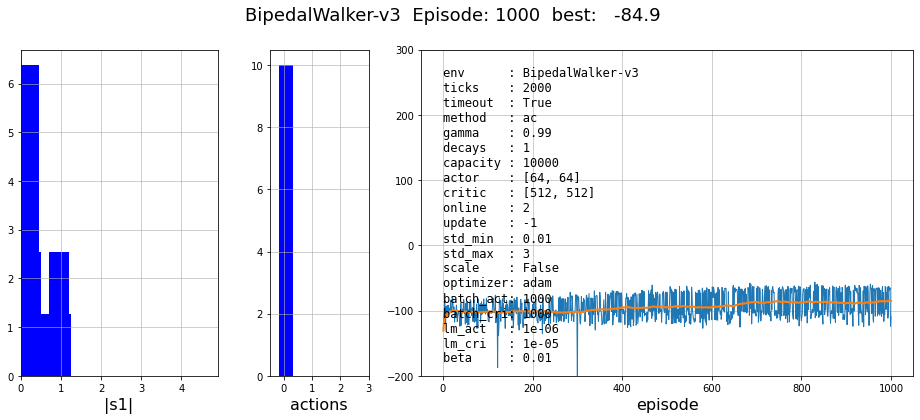

  1010 rew:  -85.5 ± 2.1 [-124.73,-59.43], best: -84.95, ticks:900, eps:0.000, mu:[ 0.141  0.203 -0.173  0.027], std:[0.582 0.549 0.532 0.518], V: -9.15 ±   nan torch.Size([1, 1]), losses (cri: 75.5241, act: -0.2823),   73s
  1020 rew:  -83.3 ± 2.1 [-124.73,-59.43], best: -83.31, ticks:991, eps:0.000, mu:[ 0.153  0.269 -0.169  0.078], std:[0.569 0.534 0.53  0.542], V: -3.05 ±   nan torch.Size([1, 1]), losses (cri: 11.9890, act:  0.1981),  124s
  1030 rew:  -82.8 ± 2.1 [-124.73,-59.43], best: -82.75, ticks:1005, eps:0.000, mu:[ 0.19   0.238 -0.187  0.069], std:[0.561 0.549 0.52  0.521], V: -2.45 ±   nan torch.Size([1, 1]), losses (cri:  5.8644, act: -0.0013),  111s
  1040 rew:  -82.1 ± 2.0 [-124.05,-59.43], best: -82.09, ticks:1036, eps:0.000, mu:[ 0.194  0.197 -0.179  0.026], std:[0.593 0.552 0.525 0.524], V: -6.40 ±   nan torch.Size([1, 1]), losses (cri: 39.7851, act: -0.0180),   72s
  1050 rew:  -82.2 ± 2.0 [-124.05,-59.43], best: -82.09, ticks:1036, eps:0.000, mu:[ 0.246  0.2   -0.2

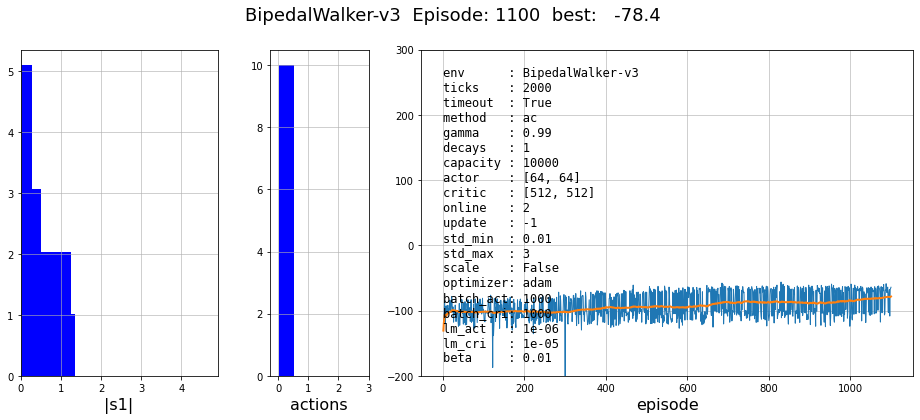

  1110 rew:  -77.7 ± 1.8 [-118.38,-58.81], best: -77.66, ticks:1189, eps:0.000, mu:[ 0.192  0.177 -0.202  0.004], std:[0.582 0.572 0.516 0.525], V: -3.15 ±   nan torch.Size([1, 1]), losses (cri: 10.4329, act:  0.0698),   99s
  1120 rew:  -77.6 ± 1.8 [-118.38,-58.81], best: -77.64, ticks:1189, eps:0.000, mu:[ 0.213  0.173 -0.206  0.018], std:[0.6   0.579 0.525 0.536], V: -1.02 ±   nan torch.Size([1, 1]), losses (cri:  0.6424, act: -0.1658),  127s
  1130 rew:  -79.0 ± 1.8 [-121.96,-58.81], best: -77.64, ticks:1159, eps:0.000, mu:[ 0.202  0.142 -0.247 -0.009], std:[0.61  0.649 0.551 0.584], V:-43.25 ±   nan torch.Size([1, 1]), losses (cri:3027.3865, act:-41.7408),   87s
  1140 rew:  -78.5 ± 1.8 [-121.96,-58.81], best: -77.64, ticks:1174, eps:0.000, mu:[ 0.272  0.254 -0.245 -0.012], std:[0.607 0.6   0.541 0.556], V: -1.75 ±   nan torch.Size([1, 1]), losses (cri:9357.8740, act:-101.5655),   86s
  1150 rew:  -78.1 ± 1.8 [-121.96,-58.81], best: -77.64, ticks:1204, eps:0.000, mu:[ 0.2    0.194

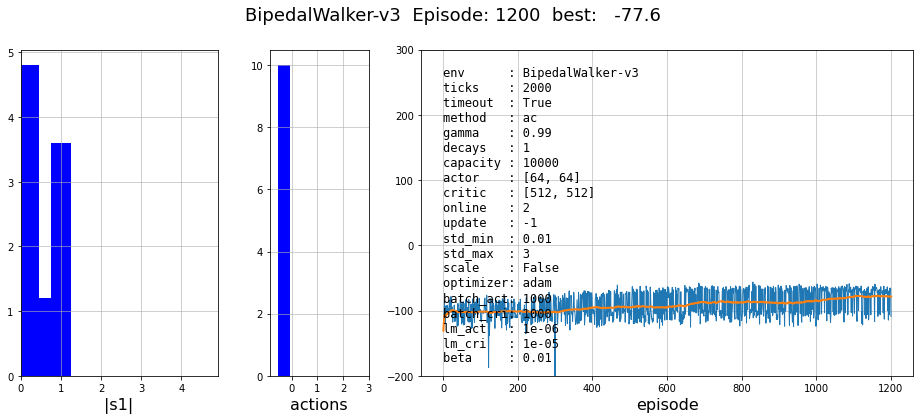

  1210 rew:  -78.7 ± 1.7 [-121.96,-59.50], best: -77.64, ticks:1219, eps:0.000, mu:[ 0.248  0.117 -0.222 -0.038], std:[0.622 0.617 0.534 0.539], V: -4.21 ±   nan torch.Size([1, 1]), losses (cri: 16.9713, act: -0.0709),  100s
  1220 rew:  -79.1 ± 1.7 [-121.96,-59.50], best: -77.64, ticks:1218, eps:0.000, mu:[ 0.278  0.123 -0.196 -0.058], std:[0.633 0.626 0.528 0.551], V: -1.40 ±   nan torch.Size([1, 1]), losses (cri:  1.7353, act: -0.0636),  126s
  1230 rew:  -77.9 ± 1.6 [-116.64,-59.50], best: -77.64, ticks:1264, eps:0.000, mu:[ 0.281  0.121 -0.194 -0.064], std:[0.643 0.633 0.534 0.557], V: -1.13 ±   nan torch.Size([1, 1]), losses (cri:  1.2682, act:  0.0084),  127s
  1240 rew:  -77.5 ± 1.5 [-116.64,-59.50], best: -77.47, ticks:1295, eps:0.000, mu:[ 0.268  0.18  -0.238  0.021], std:[0.616 0.636 0.543 0.57 ], V: -2.51 ±   nan torch.Size([1, 1]), losses (cri:  5.8661, act: -0.0593),  113s
  1250 rew:  -78.0 ± 1.5 [-116.64,-59.50], best: -77.47, ticks:1280, eps:0.000, mu:[ 0.246  0.182 -0

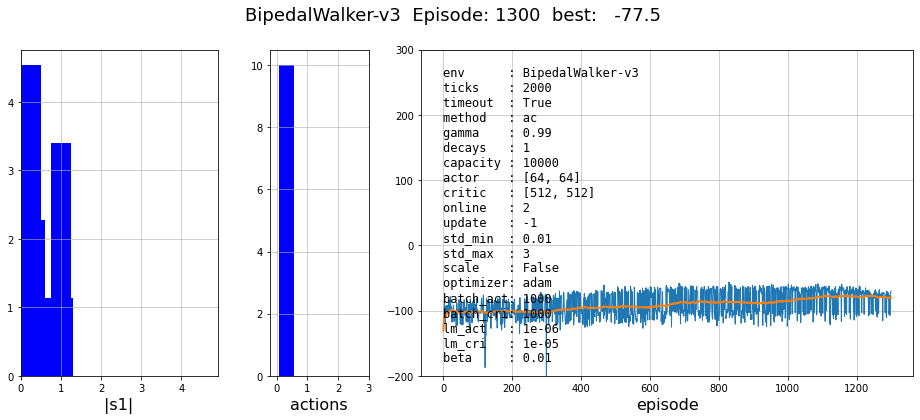

  1310 rew:  -81.2 ± 1.4 [-115.44,-65.20], best: -77.47, ticks:1266, eps:0.000, mu:[ 0.32   0.167 -0.234 -0.041], std:[0.668 0.677 0.543 0.599], V: -2.46 ±   nan torch.Size([1, 1]), losses (cri:  5.2796, act: -0.0962),   99s
  1320 rew:  -81.8 ± 1.3 [-115.44,-65.20], best: -77.47, ticks:1266, eps:0.000, mu:[ 0.311  0.139 -0.226  0.001], std:[0.645 0.689 0.555 0.59 ], V: -1.20 ±   nan torch.Size([1, 1]), losses (cri:  1.3377, act: -0.0160),  125s
  1330 rew:  -82.2 ± 1.3 [-115.44,-67.87], best: -77.47, ticks:1266, eps:0.000, mu:[ 0.355  0.164 -0.242  0.008], std:[0.65  0.684 0.556 0.612], V: -1.97 ±   nan torch.Size([1, 1]), losses (cri:  3.8027, act: -0.0088),  125s
  1340 rew:  -83.1 ± 1.3 [-115.44,-67.87], best: -77.47, ticks:1250, eps:0.000, mu:[ 0.275  0.304 -0.225 -0.033], std:[0.655 0.676 0.607 0.635], V:  6.42 ±   nan torch.Size([1, 1]), losses (cri:11120.3877, act:-83.1887),   98s
  1350 rew:  -83.2 ± 1.3 [-117.13,-67.87], best: -77.47, ticks:1265, eps:0.000, mu:[ 0.271  0.177 

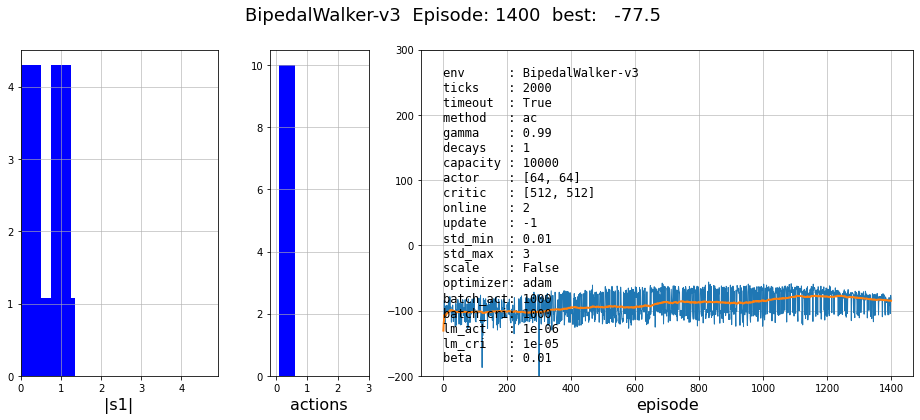

  1410 rew:  -85.5 ± 1.1 [-117.13,-70.34], best: -77.47, ticks:1309, eps:0.000, mu:[ 0.233  0.152 -0.165 -0.084], std:[0.729 0.754 0.602 0.704], V:-40.29 ±   nan torch.Size([1, 1]), losses (cri:3640.1675, act:-87.2064),   99s
  1420 rew:  -86.5 ± 1.1 [-117.13,-72.46], best: -77.47, ticks:1294, eps:0.000, mu:[ 0.375  0.156 -0.257 -0.033], std:[0.715 0.803 0.597 0.663], V: -2.49 ±   nan torch.Size([1, 1]), losses (cri:  7.1725, act:  0.1324),  111s
  1430 rew:  -87.3 ± 1.1 [-117.13,-73.76], best: -77.47, ticks:1295, eps:0.000, mu:[ 0.387  0.199 -0.263 -0.016], std:[0.741 0.831 0.615 0.688], V: -1.09 ±   nan torch.Size([1, 1]), losses (cri:  1.1934, act:  0.0046),  124s
  1440 rew:  -87.8 ± 1.0 [-117.13,-73.76], best: -77.47, ticks:1311, eps:0.000, mu:[ 0.34   0.182 -0.228 -0.061], std:[0.769 0.826 0.631 0.703], V: -2.66 ±   nan torch.Size([1, 1]), losses (cri:  6.9027, act: -0.0036),  111s
  1450 rew:  -88.4 ± 1.0 [-114.16,-73.76], best: -77.47, ticks:1326, eps:0.000, mu:[ 0.379  0.137 -

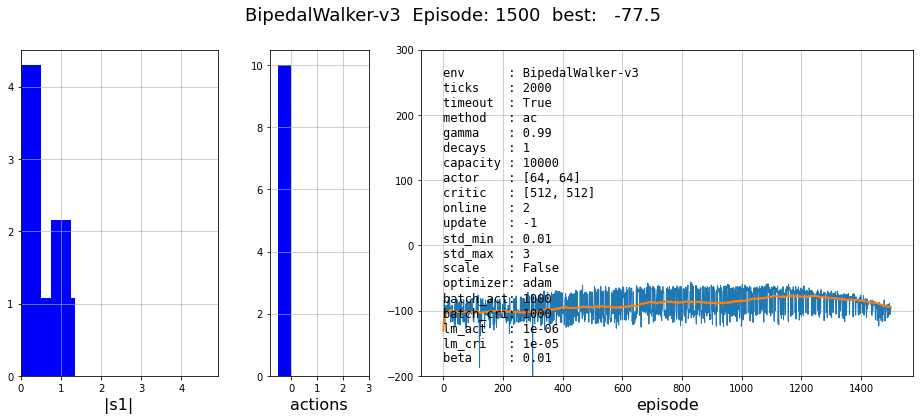

  1510 rew:  -95.8 ± 0.9 [-123.62,-81.66], best: -77.47, ticks:1266, eps:0.000, mu:[ 0.4    0.252 -0.276 -0.078], std:[0.834 0.963 0.681 0.787], V: -2.30 ±   nan torch.Size([1, 1]), losses (cri:  4.4100, act: -0.2364),  112s
  1520 rew:  -97.1 ± 0.9 [-123.62,-83.91], best: -77.47, ticks:1281, eps:0.000, mu:[ 0.505  0.249 -0.318 -0.077], std:[0.881 1.089 0.692 0.825], V: -2.86 ±   nan torch.Size([1, 1]), losses (cri:  7.8202, act: -0.0373),  125s
  1530 rew:  -98.7 ± 0.9 [-123.62,-83.91], best: -77.47, ticks:1266, eps:0.000, mu:[ 0.393  0.217 -0.238 -0.084], std:[0.823 0.949 0.657 0.809], V:-37.64 ±   nan torch.Size([1, 1]), losses (cri:3831.5706, act:-114.5693),  112s
  1540 rew: -100.0 ± 0.9 [-123.62,-83.91], best: -77.47, ticks:1235, eps:0.000, mu:[ 0.49   0.255 -0.33  -0.108], std:[0.931 1.131 0.722 0.861], V: -4.17 ±   nan torch.Size([1, 1]), losses (cri: 16.7302, act: -0.0659),   86s
  1550 rew: -101.4 ± 0.8 [-123.62,-83.91], best: -77.47, ticks:1204, eps:0.000, mu:[ 0.529  0.285 

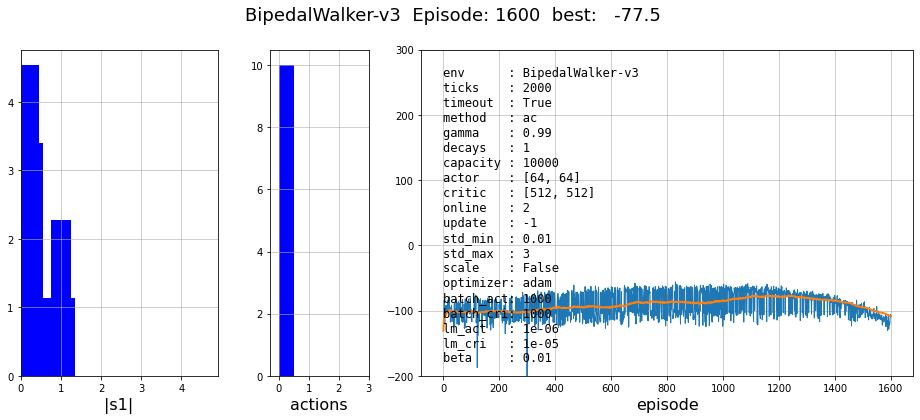

  1610 rew: -110.9 ± 0.8 [-131.54,-93.75], best: -77.47, ticks:1233, eps:0.000, mu:[ 0.487  0.393 -0.359 -0.102], std:[1.065 1.287 0.822 1.106], V:-41.00 ±   nan torch.Size([1, 1]), losses (cri:3501.3740, act:-120.0800),  111s
  1620 rew: -112.7 ± 0.8 [-132.61,-93.75], best: -77.47, ticks:1187, eps:0.000, mu:[ 0.846  0.647 -0.716 -0.071], std:[1.639 2.485 1.022 1.695], V: -4.69 ±   nan torch.Size([1, 1]), losses (cri: 21.1759, act: -0.0852),   84s
  1630 rew: -114.7 ± 0.8 [-132.61,-93.75], best: -77.47, ticks:1187, eps:0.000, mu:[ 0.859  0.741 -0.7   -0.112], std:[1.796 2.649 1.13  1.851], V: 13.00 ±   nan torch.Size([1, 1]), losses (cri:12848.4229, act:-154.7910),  111s
  1640 rew: -117.1 ± 0.9 [-138.37,-93.75], best: -77.47, ticks:1232, eps:0.000, mu:[ 0.919  0.791 -0.822  0.009], std:[2.083 3.    1.227 2.258], V: -2.21 ±   nan torch.Size([1, 1]), losses (cri:  4.5045, act: -0.1408),  123s
  1650 rew: -119.9 ± 1.0 [-145.18,-101.11], best: -77.47, ticks:1263, eps:0.000, mu:[ 0.939  0.

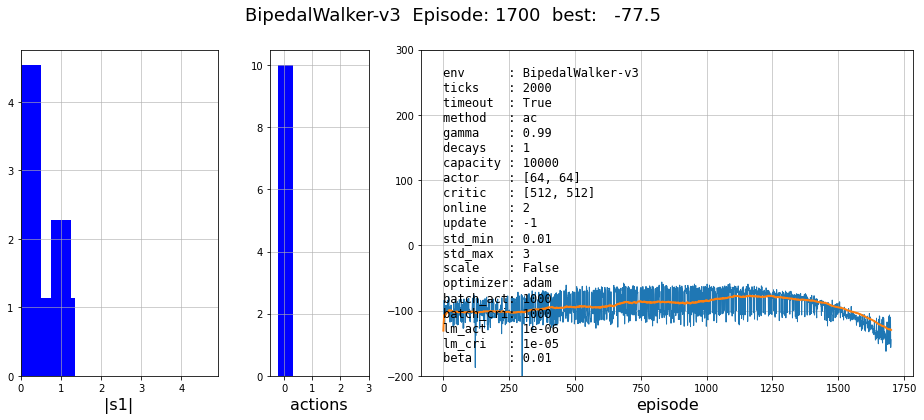

  1710 rew: -131.9 ± 1.4 [-162.46,-104.48], best: -77.47, ticks:1187, eps:0.000, mu:[ 0.895  0.842 -0.831  0.121], std:[2.039 2.547 1.707 2.195], V:-47.13 ±   nan torch.Size([1, 1]), losses (cri:2925.5750, act:-176.0789),  110s
  1720 rew: -133.9 ± 1.5 [-162.46,-106.78], best: -77.47, ticks:1234, eps:0.000, mu:[ 0.987  0.986 -0.966  0.322], std:[3. 3. 3. 3.], V: -1.73 ±   nan torch.Size([1, 1]), losses (cri:  3.1591, act:  0.0957),  123s
  1730 rew: -134.9 ± 1.5 [-166.18,-104.25], best: -77.47, ticks:1218, eps:0.000, mu:[ 0.992  0.987 -0.976  0.38 ], std:[3. 3. 3. 3.], V: -3.56 ±   nan torch.Size([1, 1]), losses (cri: 11.8903, act: -0.1870),   98s
  1740 rew: -135.4 ± 1.6 [-166.18,-104.25], best: -77.47, ticks:1172, eps:0.000, mu:[ 0.996  0.995 -0.984  0.444], std:[3. 3. 3. 3.], V: -5.30 ±   nan torch.Size([1, 1]), losses (cri: 26.8091, act: -0.2221),   85s
  1750 rew: -135.7 ± 1.6 [-166.18,-104.25], best: -77.47, ticks:1142, eps:0.000, mu:[ 0.995  0.992 -0.987  0.482], std:[3. 3. 3. 3

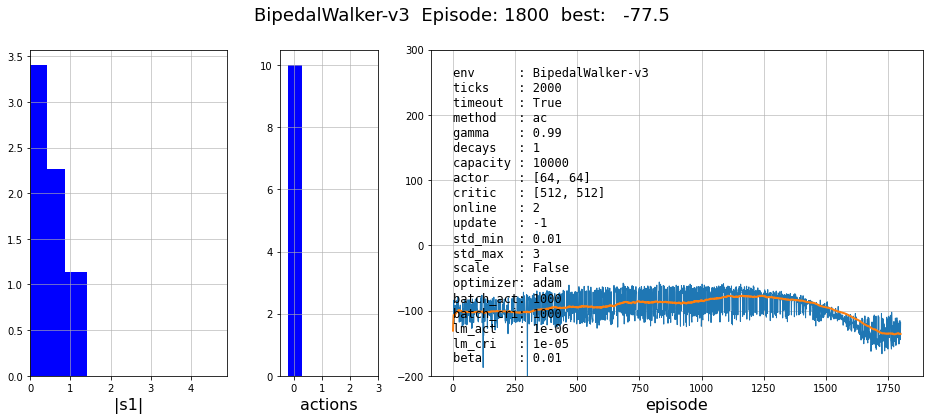

  1810 rew: -134.8 ± 1.6 [-166.18,-102.52], best: -77.47, ticks:1081, eps:0.000, mu:[ 0.956  0.929 -0.923  0.349], std:[2.316 3.    2.186 2.59 ], V:-46.51 ±   nan torch.Size([1, 1]), losses (cri:2893.8032, act:-189.6327),   85s
  1820 rew: -134.6 ± 1.6 [-166.18,-102.52], best: -77.47, ticks:1066, eps:0.000, mu:[ 0.995  0.995 -0.99   0.586], std:[3. 3. 3. 3.], V: -4.84 ±   nan torch.Size([1, 1]), losses (cri: 23.4344, act:  0.0647),  110s
  1830 rew: -134.8 ± 1.6 [-166.73,-102.52], best: -77.47, ticks:1066, eps:0.000, mu:[ 0.991  0.986 -0.982  0.519], std:[3. 3. 3. 3.], V: -3.58 ±   nan torch.Size([1, 1]), losses (cri: 13.0889, act:  0.1157),   97s
  1840 rew: -134.6 ± 1.7 [-166.73,-102.52], best: -77.47, ticks:1067, eps:0.000, mu:[ 0.994  0.991 -0.987  0.524], std:[3. 3. 3. 3.], V: -7.94 ±   nan torch.Size([1, 1]), losses (cri: 59.6649, act: -0.3350),   85s
  1850 rew: -134.5 ± 1.7 [-166.73,-102.52], best: -77.47, ticks:1067, eps:0.000, mu:[ 0.915  0.883 -0.879  0.308], std:[2.077 2.42

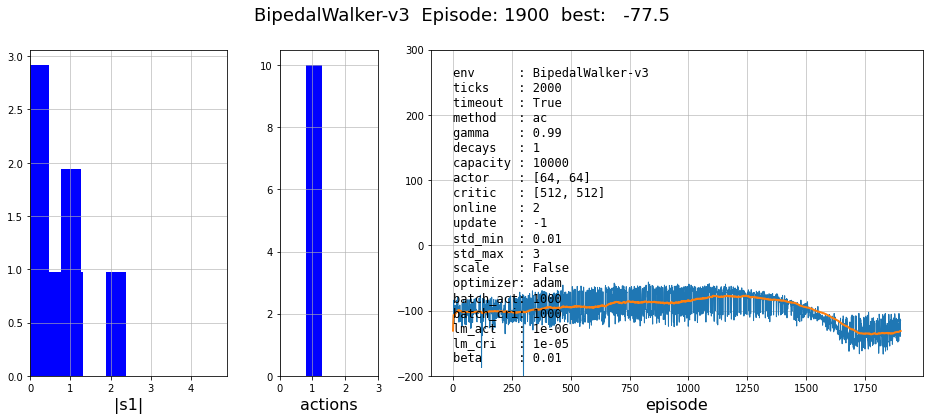

  1910 rew: -131.5 ± 1.7 [-166.73,-104.37], best: -77.47, ticks:1019, eps:0.000, mu:[ 0.998  0.997 -0.995  0.704], std:[3. 3. 3. 3.], V: -7.48 ±   nan torch.Size([1, 1]), losses (cri: 53.7199, act: -0.2067),  111s


In [ ]:
env_name = "BipedalWalker-v3" # (nS=24, nA=4)
env = gym.make(env_name)

ac = ActorCritic( env )

ac.CFG = {
            'env'         : env_name,          
            'ticks'       : 2000,            # !!!!!!!
            'timeout'     : True,           # whether to consider reaching ticks as a terminal state
            'method'      : "ac",            # kind of the method (a2c)     
            'gamma'       : 0.99,            # discount factor
            'decays'      : 1,               # number of episodes to decay eps1=1.0 - > eps2=0.01
            'capacity'    : 10000,           # size of memory            
            'actor'       : [64,64],         # hidden layers of actor
            'critic'      : [512,512],       # hidden layers of critic
            'online'      : 2,               # 0,1,2
            'update'      : -1,               # target model update rate (in frames = time steps)                     
            'std_min'     : 0.01,
            'std_max'     : 3,
            'scale'       : False,            # scale or not observe to [-1...1]            
            'optimizer'   : 'adam',          # optimizer (sgd, adam)                        
            'batch_act'   : 1000,            # batch size for training
            'batch_cri'   : 1000,            # batch size for training
            'lm_act'      : 1e-6,            # learning rate for actor model
            'lm_cri'      : 1e-5,            # learning rate for critic model
            'beta'        : 1e-2,               # entropy    
}

ac.init()
print(ac.CFG)
ac.learn(episodes = 30000, rews_range=[-200, 300])

## Test best model

In [ ]:
ac.actor.load_state_dict( ac.best_actor.state_dict() )
ac.critic.load_state_dict( ac.best_critic.state_dict() )
ac.test(episodes = 100, ticks=1000, render=False)
env.close()

   99: Reward:  96.083 ± 0.073


## Save model

In [ ]:
import datetime
  
state = {'info':      f"{env_name}: Q-function, Reward:  286",     
         'date':      datetime.datetime.now(),  
         'config':    ac.CFG,
         'actor':     str(ac.best_actor),
         'critic':    str(ac.best_critic),
         'actor_nn' : ac.best_actor.state_dict(),  
         'critic_nn' : ac.best_critic.state_dict(),  
        } 

torch.save(state, f"{env_name}.96.pt")


In [ ]:
import numpy as np
ar = np.array([[1,1],[2,0], [3,2]])
ar[ ar[:, -1].argsort() ] [::-1]

In [ ]:
ar = [ [ np.array([1,2]), np.array([3,4])], [ np.array([1,2]), np.array([3,4])] ]
np.array(ar)

In [ ]:
!pip uninstall tensorflowy
!pip install tensorflow==1.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92.6 MB 1.2 MB/s 
     |████████████████████████████████| 3.2 MB 45.2 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
     |████████████████████████████████| 367 kB 68.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
ERROR: pip's dependency resolver does not currently ta

In [ ]:
import tensorflow as tf

print(tf.__version__)

import numpy as np
import gym  #requires OpenAI gym installed
env = gym.envs.make("MountainCarContinuous-v0") 

tf.reset_default_graph()

input_dims = 2
state_placeholder = tf.placeholder(tf.float32, [None, input_dims]) 

def value_function(state):
    n_hidden1 = 400  
    n_hidden2 = 400
    n_outputs = 1
    
    with tf.variable_scope("value_network"):
        init_xavier = tf.contrib.layers.xavier_initializer()
        
        hidden1 = tf.layers.dense(state, n_hidden1, tf.nn.elu, init_xavier)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, tf.nn.elu, init_xavier) 
        V = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
        #print("V", V)
    return V


def policy_network(state):
    n_hidden1 = 40
    n_hidden2 = 40
    n_outputs = 1
    
    with tf.variable_scope("policy_network"):
        init_xavier = tf.contrib.layers.xavier_initializer()
        
        hidden1 = tf.layers.dense(state, n_hidden1, tf.nn.elu, init_xavier)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, tf.nn.elu, init_xavier)

        mu = tf.layers.dense(hidden2, n_outputs, None, init_xavier)

        sigma = tf.layers.dense(hidden2, n_outputs, None, init_xavier)
        sigma = tf.nn.softplus(sigma) + 1e-5
        
        norm_dist = tf.contrib.distributions.Normal(mu, sigma)  # mu + rnd*sigma
        
        action_tf_var = tf.squeeze(norm_dist.sample(1), axis=0)
        action_tf_var = tf.clip_by_value(action_tf_var, env.action_space.low[0], env.action_space.high[0])
        #print("norm_dist", norm_dist, "action_tf_var", action_tf_var)
    return action_tf_var, norm_dist

################################################################
#sample from state space for state normalization
import sklearn
import sklearn.preprocessing
                                    
state_space_samples = np.array(
    [env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(state_space_samples)

#function to normalize states
def scale_state(state):                 #requires input shape=(2,)
    scaled = scaler.transform([state])
    return scaled                       #returns shape =(1,2)   
###################################################################

lr_actor =  0.00002  #set learning rates     # !!!
lr_critic = 0.001                            # !!!

# define required placeholders
action_placeholder = tf.placeholder(tf.float32)
delta_placeholder  = tf.placeholder(tf.float32)
target_placeholder = tf.placeholder(tf.float32)

action_tf_var, norm_dist = policy_network(state_placeholder)
V = value_function(state_placeholder)

# define actor (policy) loss function
loss_actor = -tf.log(norm_dist.prob(action_placeholder) + 1e-5) * delta_placeholder

training_op_actor = tf.train.AdamOptimizer(lr_actor, name='actor_optimizer').minimize(loss_actor)

# define critic (state-value) loss function
loss_critic = tf.reduce_mean(tf.squared_difference(tf.squeeze(V), target_placeholder))

training_op_critic = tf.train.AdamOptimizer(lr_critic, name='critic_optimizer').minimize(loss_critic)
################################################################
#Training loop
gamma = 0.99        #discount factor
num_episodes = 300

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    episode_history = []
    for episode in range(num_episodes):
        #receive initial state from E
        state = env.reset()   # state.shape -> (2,)
        reward_total = 0 
        steps = 0
        done = False
        while (not done):
                
            #Sample action according to current policy
            #action.shape = (1,1)
            action  = sess.run(action_tf_var, feed_dict={state_placeholder: scale_state(state)})
            
            #Execute action and observe reward & next state from E
            # next_state shape=(2,)    
            #env.step() requires input shape = (1,)
            next_state, reward, done, _ = env.step(np.squeeze(action, axis=0)) 
            steps +=1
            reward_total += reward
            print(f"{steps}:{reward_total:.1f}", end=", ")
            #V_of_next_state.shape=(1,1)
            V_of_next_state = sess.run(V, feed_dict = {state_placeholder: scale_state(next_state)})  
            #Set TD Target
            #target = r + gamma * V(next_state)     
            target = reward + gamma * np.squeeze(V_of_next_state) 
            
            # td_error = target - V(s)
            #needed to feed delta_placeholder in actor training
            td_error = target - np.squeeze(sess.run(V, feed_dict = {state_placeholder: scale_state(state)})) 
            
            #Update actor by minimizing loss (Actor training)
            _, loss_actor_val  = sess.run(  [training_op_actor, loss_actor],   feed_dict={action_placeholder: np.squeeze(action), 
                                                                                          state_placeholder: scale_state(state), 
                                                                                          delta_placeholder: td_error})
            #Update critic by minimizinf loss  (Critic training)
            _, loss_critic_val  = sess.run( [training_op_critic, loss_critic], feed_dict={state_placeholder: scale_state(state), 
                                                                                          target_placeholder: target})
            
            state = next_state
            #end while
        episode_history.append(reward_total)
        print("\nEpisode: {}, Number of Steps : {}, Cumulative reward: {:0.2f}".format(episode, steps, reward_total))
        
        if np.mean(episode_history[-100:]) > 90 and len(episode_history) >= 101:
            print("****************Solved***************")
            print("Mean cumulative reward over 100 episodes:{:0.2f}" .format(
                np.mean(episode_history[-100:])))
            
 

1.13.1
1:-0.0, 2:-0.0, 3:-0.0, 4:-0.1, 5:-0.1, 6:-0.1, 7:-0.1, 8:-0.1, 9:-0.1, 10:-0.2, 11:-0.3, 12:-0.3, 13:-0.4, 14:-0.4, 15:-0.5, 16:-0.6, 17:-0.7, 18:-0.7, 19:-0.7, 20:-0.7, 21:-0.8, 22:-0.8, 23:-0.8, 24:-0.8, 25:-0.9, 26:-1.0, 27:-1.0, 28:-1.1, 29:-1.2, 30:-1.2, 31:-1.2, 32:-1.2, 33:-1.3, 34:-1.3, 35:-1.4, 36:-1.4, 37:-1.4, 38:-1.4, 39:-1.4, 40:-1.5, 41:-1.5, 42:-1.5, 43:-1.6, 44:-1.6, 45:-1.6, 46:-1.7, 47:-1.8, 48:-1.8, 49:-1.8, 50:-1.8, 51:-1.8, 52:-1.8, 53:-1.8, 54:-1.8, 55:-1.9, 56:-1.9, 57:-2.0, 58:-2.0, 59:-2.0, 60:-2.1, 61:-2.1, 62:-2.2, 63:-2.2, 64:-2.3, 65:-2.3, 66:-2.3, 67:-2.4, 68:-2.4, 69:-2.4, 70:-2.4, 71:-2.4, 72:-2.4, 73:-2.5, 74:-2.6, 75:-2.7, 76:-2.8, 77:-2.8, 78:-2.8, 79:-2.9, 80:-2.9, 81:-3.0, 82:-3.0, 83:-3.1, 84:-3.2, 85:-3.2, 86:-3.2, 87:-3.3, 88:-3.4, 89:-3.5, 90:-3.5, 91:-3.6, 92:-3.7, 93:-3.7, 94:-3.7, 95:-3.7, 96:-3.8, 97:-3.8, 98:-3.8, 99:-3.8, 100:-3.8, 101:-3.8, 102:-3.9, 103:-3.9, 104:-3.9, 105:-3.9, 106:-4.0, 107:-4.0, 108:-4.1, 109:-4.1, 110:-4.1, 1

KeyboardInterrupt: ignored